# MODULO 5

Regresion y Clasificación con scikit-learn

## IMPORTAR LIBRERIAS

In [3]:
# Librerias principales

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocesados

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, OneHotEncoder, LabelEncoder

# Imputadores

from sklearn.impute import SimpleImputer, KNNImputer

# Regresion y Clasificacion

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC

# Metricas

from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, recall_score

## CARGA DE DATOS Y PRIMERAS COMPROBACIONES

In [26]:
df = pd.read_csv("AB_NYC_2019.csv")
df.drop(['id', 'host_id', 'host_name','last_review'], axis=1, inplace=True)
names = df['name']
df.drop('name', axis=1, inplace=True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Despues de cargar los datos con los que vamos a trabajar en el ejercicio vamos a comprobar si tiene valores nulos

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


Tenemos 16 nulos en name y 10052 tanto en Last review como en reviews per month

## Primeros EDAS

Como queremos hacer una regresión que prediga el precio del alojamiento y una clasificación para calcular el room_type voy a hacer unos EDAS en torno a esas variables para ver que me muestran

### Histograma Precios

<Axes: xlabel='price', ylabel='Count'>

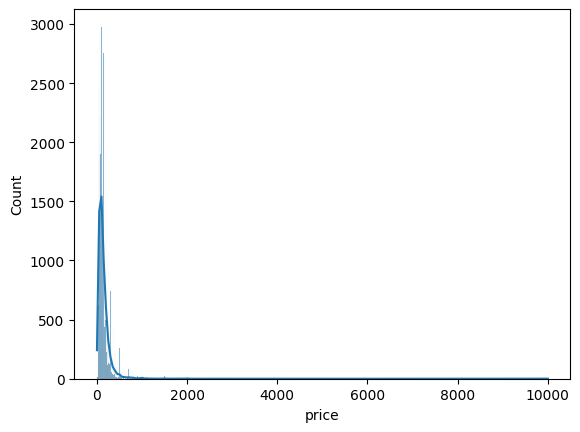

In [28]:
sns.histplot(df, x='price', kde=True)

Podemos ver claramente que hay algun tipo de outlier en esta columna porque el precio se va hasta los 10000$, voy a comprobarlo con un boxplot

### Boxplot precios dividido por tipo de habitación

<Axes: ylabel='price'>

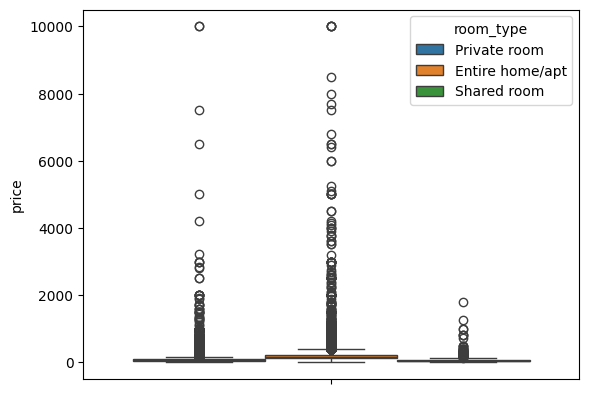

In [29]:
sns.boxplot(df, hue='room_type', y='price')

Confirmo que hay muchos outliers pero como no voy a querer perderlos a la hora de trabajar con los datos voy a realizar una transformación logaritmica que me va a reducir en gran medida los mismos

### Countvalues por Tipo de habitación

<Axes: xlabel='room_type', ylabel='count'>

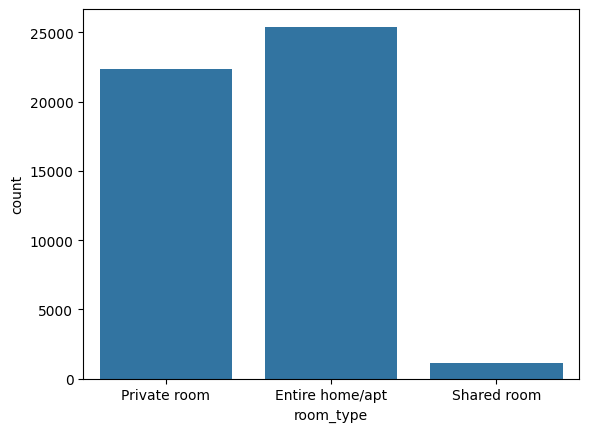

In [30]:
sns.countplot(df, x='room_type')

Como el tipo de habitación Shared hay muy pocos datos comparados con el de los otros 2 tipos de habitación se podria intentar realizar un SMOTE

### Pairplot

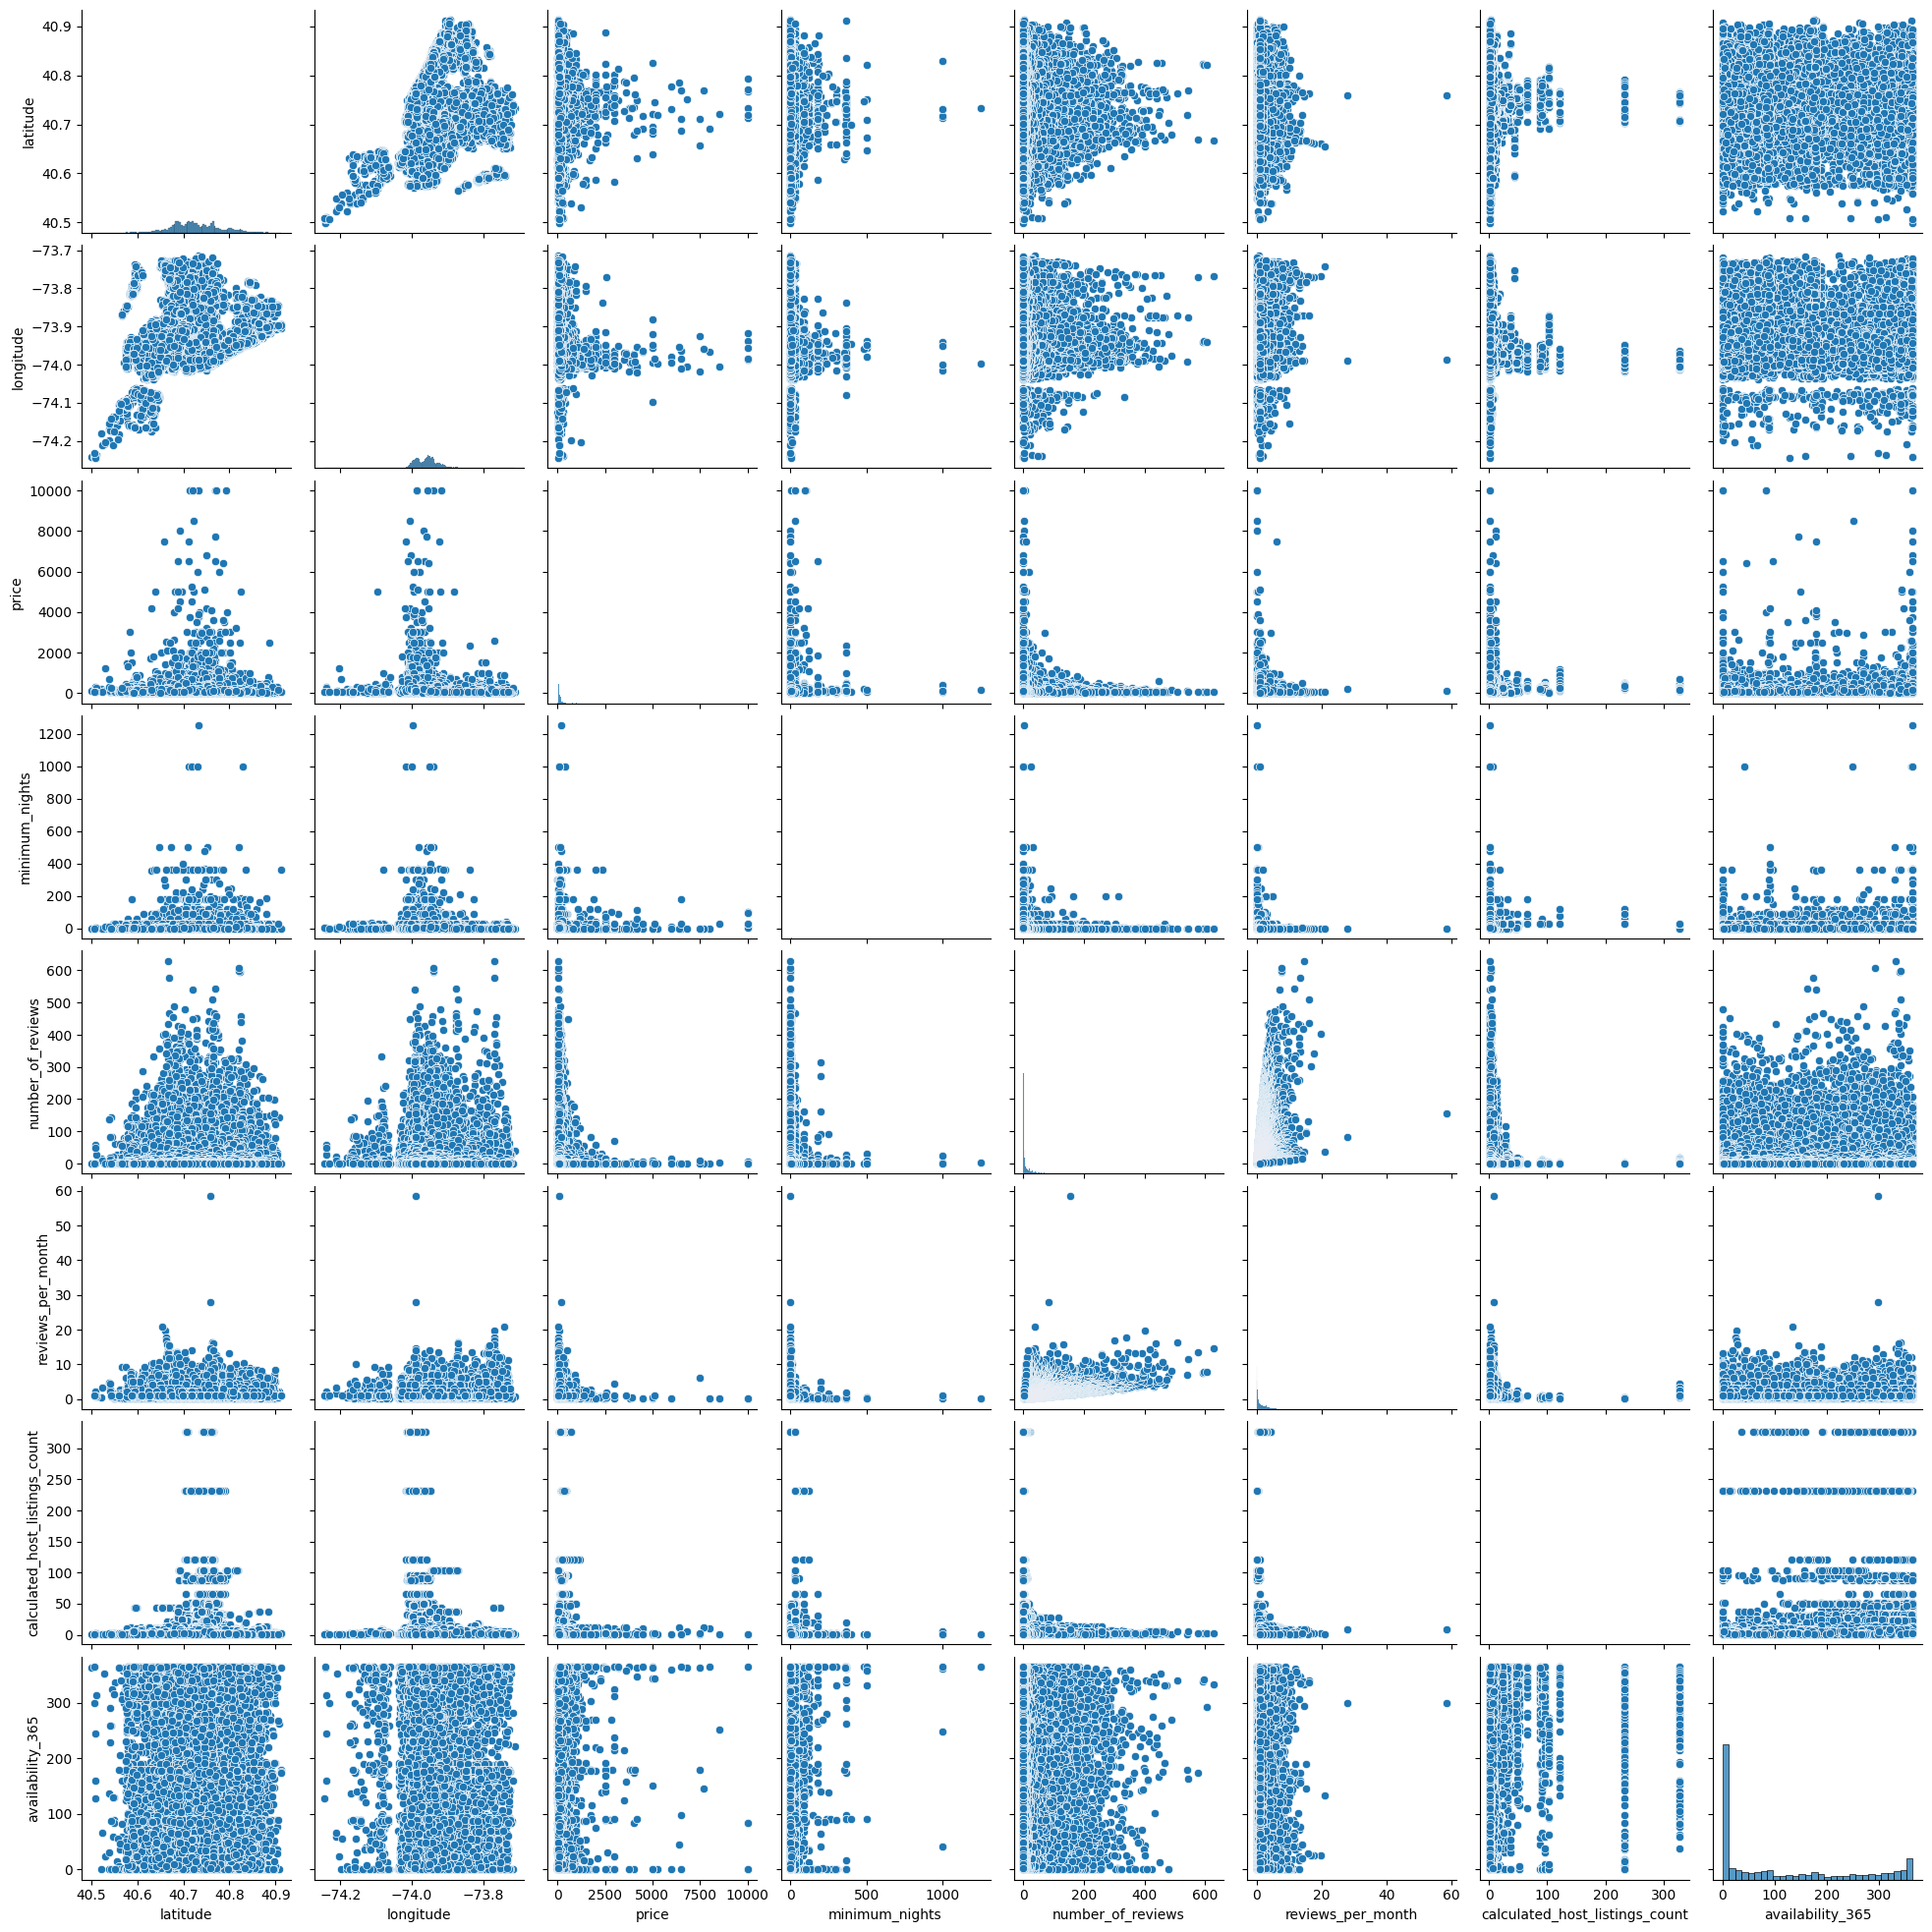

In [31]:
sns.pairplot(df)

Asi de primeras parece que ninguna variable numerica tiene una correlación directa entre si, solo la longitud y la latitud, vamos a comprobarlo ahora con una matriz de correlacion de las variable numericas

### Matriz correlacion variables numericas

<Axes: >

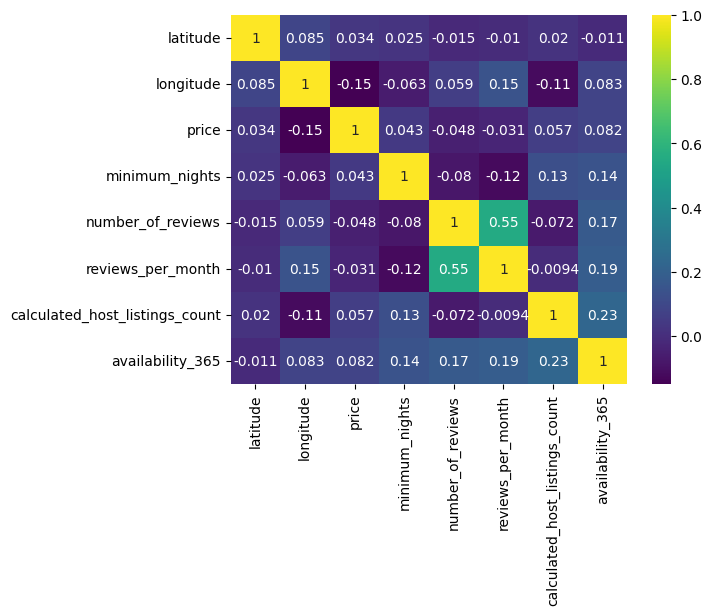

In [32]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')

Como sospechamos anteriormente no hay una relación directa de ninguna de las varibles con el precio supongo que por la cantidad de outliers.

Antes de realizar el entrenamiento y el trabajo con las variables, voy a ver que relación hay en caso transformar logaritmicamente el precio.

Lo hago para comprobar como cambian los datos.

Por eso lo voy a hacer en una copia del dataframe, por que esta copia no es la que vamos a usar en el entrenamiento ni la division de los datos

In [45]:
df2 = df.copy()
df2.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


c:\Users\p-rom\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

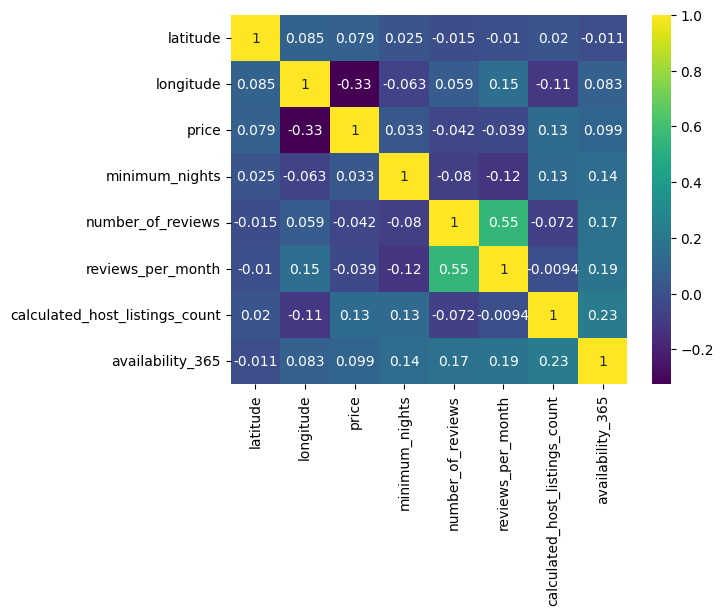

In [46]:
df2['price'] = np.log(df2['price'])

sns.heatmap(df2.corr(numeric_only=True), annot=True, cmap='viridis')

Se puede ver que ha mejorado un poco la correlacion usando la transformacion logaritmica

## COMPROBACION DE QUE COLUMNAS TIENEN UNA CORRELACION MAYOR A 0.1 O MENOR A -0.1 RESPECTO AL PRECIO EN EL DF ORIGINAL

([0, 1, 2, 3],
 [Text(0, 0, 'room_type_Entire home/apt'),
  Text(1, 0, 'neighbourhood_group_Manhattan'),
  Text(2, 0, 'longitude'),
  Text(3, 0, 'room_type_Private room')])

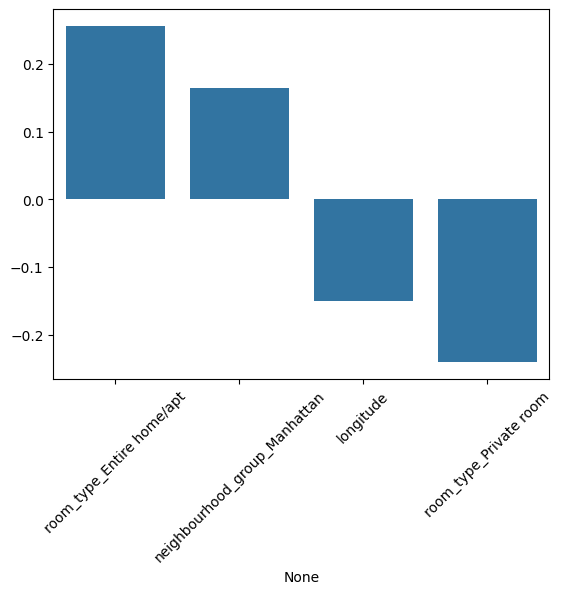

In [42]:
price_correlation=pd.get_dummies(df).corr()['price'].drop(['price'])

#price_correlation
filter = (price_correlation > 0.1) | (price_correlation < -0.1)
filtered_corretation = price_correlation[filter]

filtered_corretation.sort_values(ascending=False, inplace=True)
sns.barplot(x=filtered_corretation.index, y=filtered_corretation.values)
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'room_type_Entire home/apt'),
  Text(1, 0, 'neighbourhood_group_Manhattan'),
  Text(2, 0, 'neighbourhood_Midtown'),
  Text(3, 0, 'calculated_host_listings_count'),
  Text(4, 0, 'neighbourhood_Chelsea'),
  Text(5, 0, 'neighbourhood_West Village'),
  Text(6, 0, "neighbourhood_Hell's Kitchen"),
  Text(7, 0, 'neighbourhood_group_Bronx'),
  Text(8, 0, 'neighbourhood_Bedford-Stuyvesant'),
  Text(9, 0, 'neighbourhood_Bushwick'),
  Text(10, 0, 'room_type_Shared room'),
  Text(11, 0, 'neighbourhood_group_Queens'),
  Text(12, 0, 'neighbourhood_group_Brooklyn'),
  Text(13, 0, 'longitude'),
  Text(14, 0, 'room_type_Private room')])

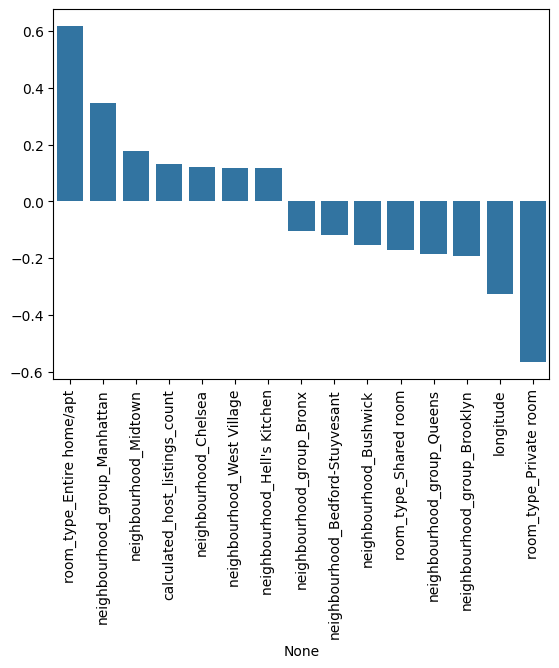

In [49]:
price_correlation=pd.get_dummies(df2).corr()['price'].drop(['price'])

#price_correlation
filter = (price_correlation > 0.1) | (price_correlation < -0.1)
filtered_corretation = price_correlation[filter]

filtered_corretation.sort_values(ascending=False, inplace=True)
sns.barplot(x=filtered_corretation.index, y=filtered_corretation.values)
plt.xticks(rotation=90)

Observamos que gracias a la transformacion logaritmica hay muchos mas campos que tienen una correlacion absoluta mayor a |0.1|

Pasando de 4 sin transformar a 15 transformadas

Aunque en ningun caso tiene una gran correlacion

## COMPROBACION DE OUTLIERS

<Axes: xlabel='price', ylabel='Count'>

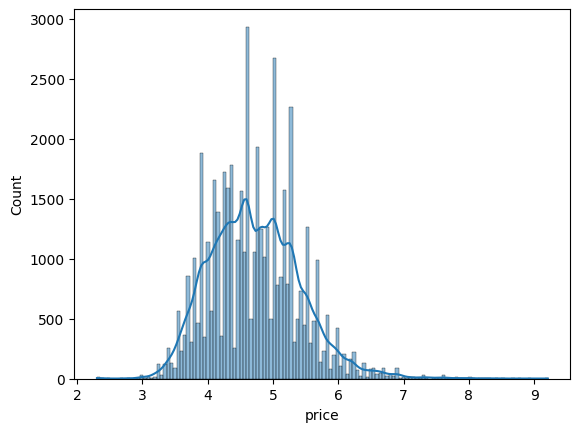

In [50]:
sns.histplot(df2, x='price', kde=True)

<Axes: ylabel='price'>

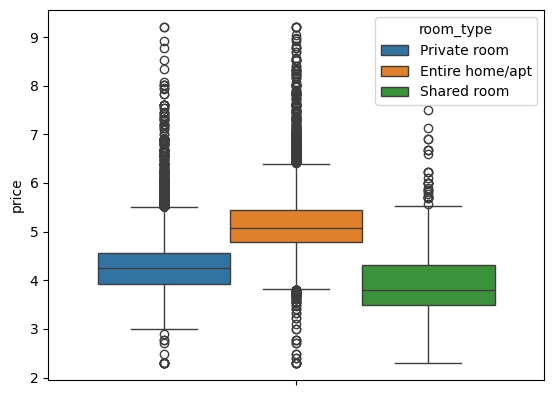

In [51]:
sns.boxplot(df2, y='price', hue='room_type')

Podemos observar que sigue habiendo outliers y vamos a ver cuantos outliers habria en cada uno de los 2 (sin transformar y transformado)

Todavia no he emprezado con los preprocesados ni con el calculo, esto es solo un analisis visual del problema por eso estoy usando getdumies y np.log para realizar transformaciones y todo

### CONTAR OUTLIERS SIN TRANSFORMAR PRECIO

In [52]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 + 1.5*IQR

filtro = filtro = ~((df['price'] < lower_bound) | (df['price'] > upper_bound))
print(df.shape)
print(df[filtro].shape)
print(f'Filas eliminadas {df.shape[0]-df[filtro].shape[0]} - {round(100*(df.shape[0]-df[filtro].shape[0])/df.shape[0],2)}%')

(48895, 11)
(45923, 11)
Filas eliminadas 2972 - 6.08%


### CONTAR OUTLIERS TRANSFORMANDO PRECIO

In [53]:
Q1 = df2['price'].quantile(0.25)
Q3 = df2['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound= Q1 - 1.5*IQR
upper_bound= Q3 + 1.5*IQR

filtro = filtro = ~((df2['price'] < lower_bound) | (df2['price'] > upper_bound))
print(df2.shape)
print(df2[filtro].shape)
print(f'Filas eliminadas {df2.shape[0]-df2[filtro].shape[0]} - {round(100*(df2.shape[0]-df2[filtro].shape[0])/df2.shape[0],2)}%')

(48895, 11)
(48258, 11)
Filas eliminadas 637 - 1.3%


Podemos comprobrar que la transformacion logaritmica ha convertido en valores validos muchos outliers

### MATRIZ DE CORRELACION SIN TRANSFORMACION DE PRECIO Y SIN OUTLIERS

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'room_type_Entire home/apt'),
  Text(1, 0, 'neighbourhood_group_Manhattan'),
  Text(2, 0, 'neighbourhood_Midtown'),
  Text(3, 0, 'calculated_host_listings_count'),
  Text(4, 0, 'neighbourhood_Chelsea'),
  Text(5, 0, 'neighbourhood_West Village'),
  Text(6, 0, "neighbourhood_Hell's Kitchen"),
  Text(7, 0, 'availability_365'),
  Text(8, 0, 'neighbourhood_Bedford-Stuyvesant'),
  Text(9, 0, 'room_type_Shared room'),
  Text(10, 0, 'neighbourhood_Bushwick'),
  Text(11, 0, 'neighbourhood_group_Queens'),
  Text(12, 0, 'neighbourhood_group_Brooklyn'),
  Text(13, 0, 'longitude'),
  Text(14, 0, 'room_type_Private room')])

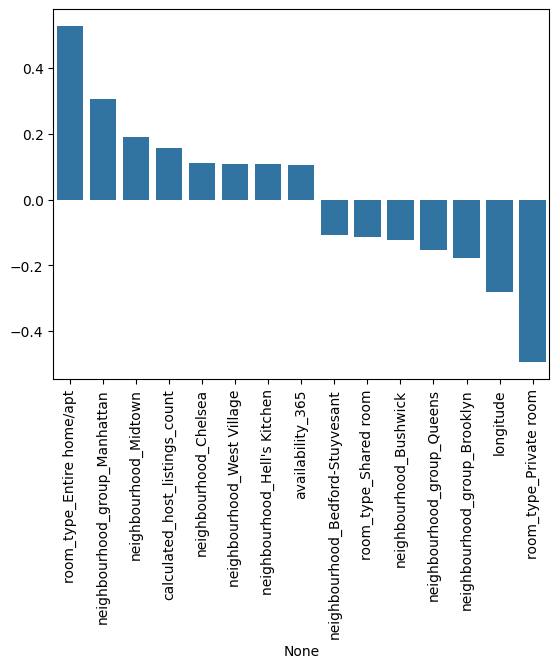

In [54]:
df_ultimo_analisis_previo = df.copy()
df_ultimo_analisis_previo = df_ultimo_analisis_previo[filtro]
price_correlation=pd.get_dummies(df_ultimo_analisis_previo).corr()['price'].drop(['price'])

filter = (price_correlation > 0.1) | (price_correlation < -0.1)
filtered_corretation = price_correlation[filter]

filtered_corretation.sort_values(ascending=False, inplace=True)
sns.barplot(x=filtered_corretation.index, y=filtered_corretation.values)
plt.xticks(rotation=90)

### MATRIZ DE CORRELACION CON TRANSFORMACION DE PRECIO Y SIN OUTLIERS

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'room_type_Entire home/apt'),
  Text(1, 0, 'neighbourhood_group_Manhattan'),
  Text(2, 0, 'neighbourhood_Midtown'),
  Text(3, 0, 'calculated_host_listings_count'),
  Text(4, 0, "neighbourhood_Hell's Kitchen"),
  Text(5, 0, 'neighbourhood_Chelsea'),
  Text(6, 0, 'neighbourhood_West Village'),
  Text(7, 0, 'neighbourhood_Financial District'),
  Text(8, 0, 'neighbourhood_group_Bronx'),
  Text(9, 0, 'neighbourhood_Bedford-Stuyvesant'),
  Text(10, 0, 'neighbourhood_Bushwick'),
  Text(11, 0, 'room_type_Shared room'),
  Text(12, 0, 'neighbourhood_group_Queens'),
  Text(13, 0, 'neighbourhood_group_Brooklyn'),
  Text(14, 0, 'longitude'),
  Text(15, 0, 'room_type_Private room')])

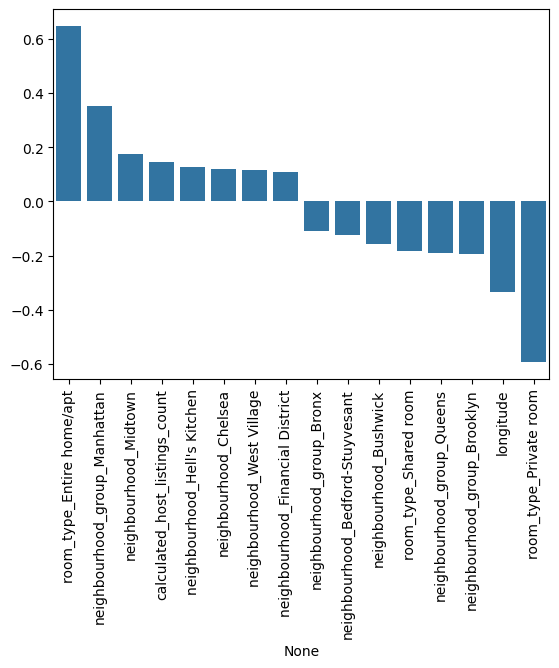

In [55]:
df2_ultimo_analisis_previo = df2.copy()
df2_ultimo_analisis_previo = df2_ultimo_analisis_previo[filtro]
price_correlation=pd.get_dummies(df2_ultimo_analisis_previo).corr()['price'].drop(['price'])

filter = (price_correlation > 0.1) | (price_correlation < -0.1)
filtered_corretation = price_correlation[filter]

filtered_corretation.sort_values(ascending=False, inplace=True)
sns.barplot(x=filtered_corretation.index, y=filtered_corretation.values)
plt.xticks(rotation=90)

Se puede comprobar que la mejor estrategia es realizar una transformacion logaritmica del precio y no tener en cuenta los outliers asi que vamos a trabajar de ese modo a la hora de realizar nuestro trabajo

## CARGAR DE NUEVO LOS DATOS NECESARIOS Y EMPEZAR A CON LOS PREPORCESADOS

In [20]:
df = pd.read_csv("AB_NYC_2019.csv")
df.drop(['id', 'host_id', 'host_name'], axis=1, inplace=True)
df.head()

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
